In [115]:
# Importação de bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [116]:
# Conexão entre o Google Colab e o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
# Criação de função para o pré-processamento dos dados
# A execução de todas as funções será realizada na última célula

def load_and_preprocess_data(filepath, start_date, end_date):
    # Leitura do conjunto de dados
    df = pd.read_csv("/content/drive/MyDrive/CEPEA.csv")

    # Renomeação das colunas de preço
    df.rename(columns={
        'valor_reais': 'preco_reais',
        'valor_dolares': 'preco_dolares'
    }, inplace=True)

    # Conversão da coluna 'data' para o formato datetime
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y', dayfirst=True, errors='coerce')

    # Filtragem dos dados para o período desejado
    df = df[(df['data'] >= start_date) & (df['data'] <= end_date)]

    # Ordenação ascendente dos dados pela coluna 'data'
    df.sort_values(by='data', ascending=True, inplace=True)

    # Redefinição do índice do conjunto de dados
    df.reset_index(drop=True, inplace=True)

    return df

In [127]:
# Visualização dos dados
def plot_data(df):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, 8))
    sns.lineplot(x="data", y="preco_reais", data=df, color="#8c94d7", linewidth=2)
    plt.title("Preços de Café Arábica no Brasil", fontsize=16, fontweight="bold", color="#333333")
    plt.xlabel("Ano", fontsize=14, color="#333333")
    plt.ylabel("Preço (R$)", fontsize=14, color="#333333")
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(visible=True, color="#dddddd", linestyle="--", linewidth=0.7)
    plt.show()

In [128]:
# Preparação dos dados para o LSTM
def prepare_data(df, column, window_size, train_split=0.8):
    # Extração dos dados da coluna desejada ('preco_reais')
    price = df[[column]].values

    # Normalização dos dados em uma escala 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(price)

    # Divisão dos dados para treinamento (80%) e teste (20%) do modelo
    train_size = int(len(scaled_data) * train_split)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - window_size:]

    # Criação das sequências de dados para o LSTM
    def create_sequences(data, window_size):
        X, y = [], []
        for i in range(window_size, len(data)):
            X.append(data[i - window_size:i, 0])  # Collect 'window_size' steps of data for X
            y.append(data[i, 0])  # The next value (the target) for y
        return np.array(X), np.array(y)

    # Criação sequências para dados de treinamento e teste
    X_train, y_train = create_sequences(train_data, window_size)
    X_test, y_test = create_sequences(test_data, window_size)

    # Remodelação dos dados para o formato 3D conforme exigido pelo LSTM (amostras, passos_de_tempo, características)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test, scaler

In [129]:
# Construção do modelo LSTM multicamadas
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=512, return_sequences=True, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=256, return_sequences=False, activation='relu'),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae'])
    return model

In [130]:
# Avaliação do modelo LSTM
def evaluate_model(y_test, y_pred, scaler):
    # Transformação inversa dos valores normalizados
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")

    return mae, mape, rmse

In [133]:
# Visualização das previsões
def plot_predictions(df, train_size, y_test, y_pred):
    plt.figure(figsize=(16, 8))
    train = df[:train_size]
    valid = df[train_size:].copy()
    valid["Previsões"] = scaler.inverse_transform(y_pred.reshape(-1, 1))

    plt.plot(df["data"], df["preco_reais"], label="Dados reais", color="#8c94d7")
    plt.plot(valid["data"], valid["preco_reais"], label="Validação", color="#f57f42")
    plt.plot(valid["data"], valid["Previsões"], label="Dados previstos", color="#6dbf76")
    plt.title("Previsão de Preços de Café Arábica no Brasil", fontsize=16)
    plt.xlabel("Ano", fontsize=14)
    plt.ylabel("Preço (R$)", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

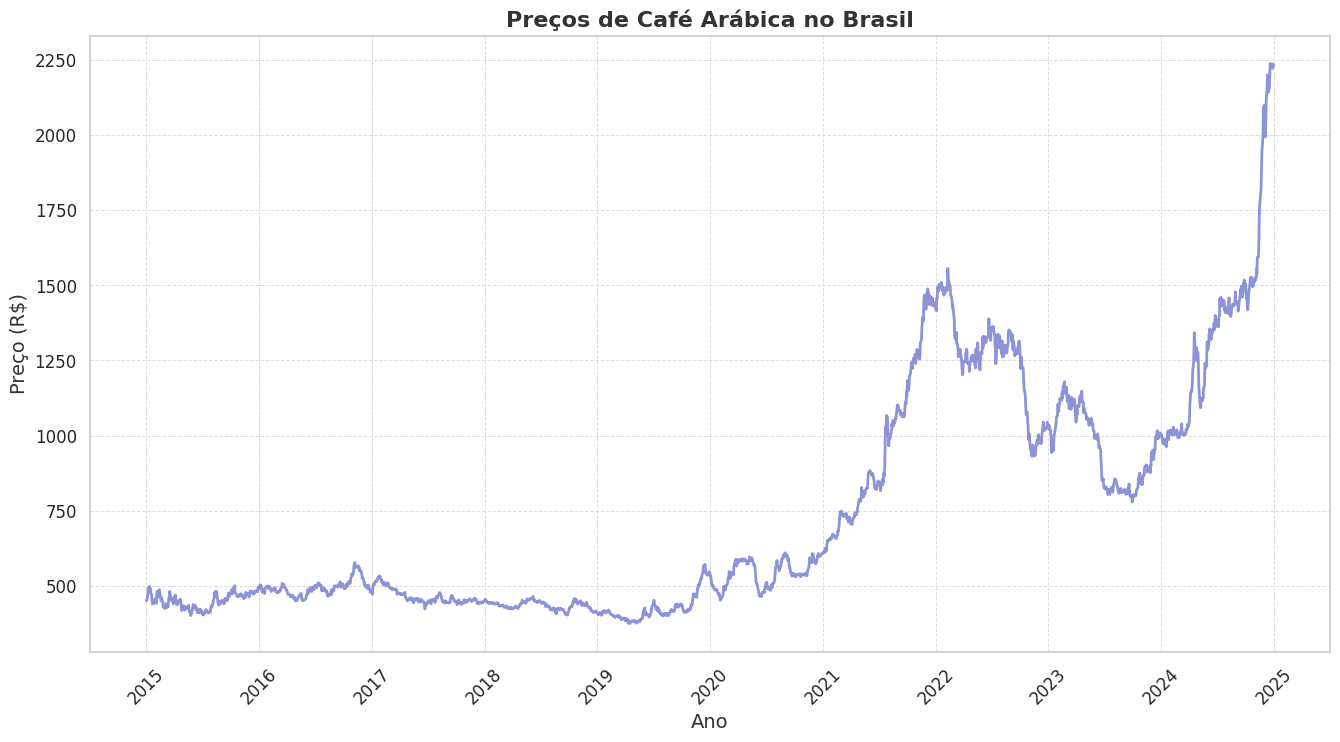

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 0.0078 - mae: 0.0486
Epoch 2/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 4.4647e-04 - mae: 0.0132
Epoch 3/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 3.9757e-04 - mae: 0.0123
Epoch 4/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 4.0806e-04 - mae: 0.0130
Epoch 5/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 5.1665e-04 - mae: 0.0148
Epoch 6/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 5.1463e-04 - mae: 0.0147
Epoch 7/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 3.4742e-04 - mae: 0.0120
Epoch 8/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 5.6901e-04 - mae: 0.0162
Epoch 9/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 3.5424e-04 - mae: 0.0120
Epoch 10/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 3.2480e-04 - mae: 0.0119
Epoch 11/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 3.0785e-04 - mae: 0.0111
Epoch 12/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 3.1393e-04 - mae: 0.0113
Epoch

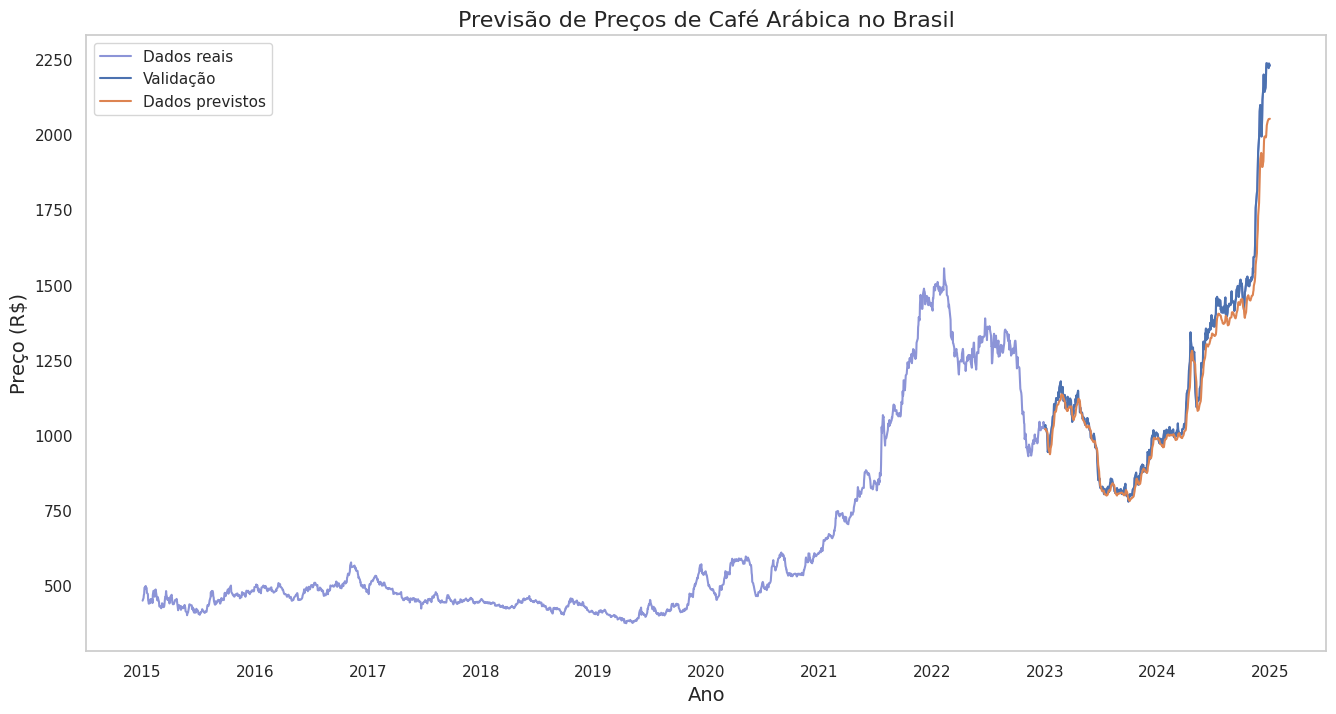

In [132]:
# Fluxo principal
# Aplicação das funções

if __name__ == "__main__":
    filepath = "/content/drive/MyDrive/CEPEA.csv"
    df = load_and_preprocess_data(filepath, '2015-01-01', '2025-01-01')

    plot_data(df)

    window_size = 60
    X_train, y_train, X_test, y_test, scaler = prepare_data(df, "preco_reais", window_size)

    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=35, batch_size=32, verbose=1)

    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, scaler)

    train_size = int(len(df) * 0.8)
    plot_predictions(df, train_size, y_test, y_pred)